#Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
import seaborn as sns
import time

#Hyper-Parâmetros

In [2]:
bs=64
lr=0.005
beta1=0.5
beta2=0.999
num_epochs = 60
ngpu = 1
L1_lambda = 100

SEED = 42
np.random.seed(SEED)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Importe do DataLoader e o carregamento dele em Batches

In [3]:
image_dir  = '/content/drive/MyDrive/Tumor/Datasets'
data_dir  = '/content/drive/MyDrive/Tumor/'

train_size = 0.8
val_size = 0.2

for root, dirs, files in os.walk(image_dir):
    print(os.walk(image_dir))
    if len(files) > 0:
        train_files, val_files = train_test_split(files, test_size=(1 - train_size), random_state=42)
        for split_name,files in zip(["train","val"],[train_files,val_files]):
            output_dir = os.path.join(data_dir, split_name, os.path.relpath(root, image_dir))
            os.makedirs(output_dir, exist_ok=True)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(output_dir, file)
                shutil.move(src, dst)

<generator object _walk at 0x7bb7086fe420>
<generator object _walk at 0x7bb7086fe650>
<generator object _walk at 0x7bb7086fdf50>
<generator object _walk at 0x7bb7086fe6c0>
<generator object _walk at 0x7bb7086fe5e0>


In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

train_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Tumor/train", transform=train_transform)
val_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/Tumor/val", transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=bs,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=bs,shuffle=False)

Train set
glioma: 720 / meningioma: 679 /normal: 0 / pituitary: 0


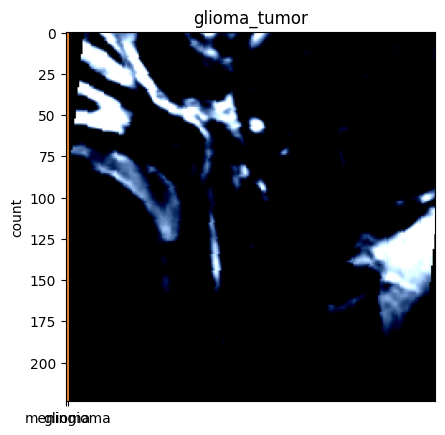

In [5]:
# train set distribution
counter = []
x_g = 0
x_m = 0
x_n = 0
x_p = 0

for i in train_set:
    if i[1] == 0:
        counter.append("glioma")
        x_g += 1
    elif i[1] == 1:
        counter.append("meningioma")
        x_m += 1
    elif i[1] == 2:
        counter.append("normal")
        x_n += 1
    else:
        counter.append("pituitary")
        x_p += 1

print('Train set')
print('glioma:', x_g, '/ meningioma:', x_m,'/normal:', x_n, '/ pituitary:', x_p)
sns.countplot(x=counter);

class_names = train_set.classes

plt.imshow(train_set[0][0].transpose(0,2).transpose(1,0))
plt.title(train_set.classes[train_set[0][1]])
plt.show()

#Definição da função para mostrar a imagem

In [6]:
def show_image(img, title="No title", figsize=(5,5)):
    img = img.numpy().transpose(1,2,0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    img = img * std + mean
    np.clip(img, 0, 1)

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

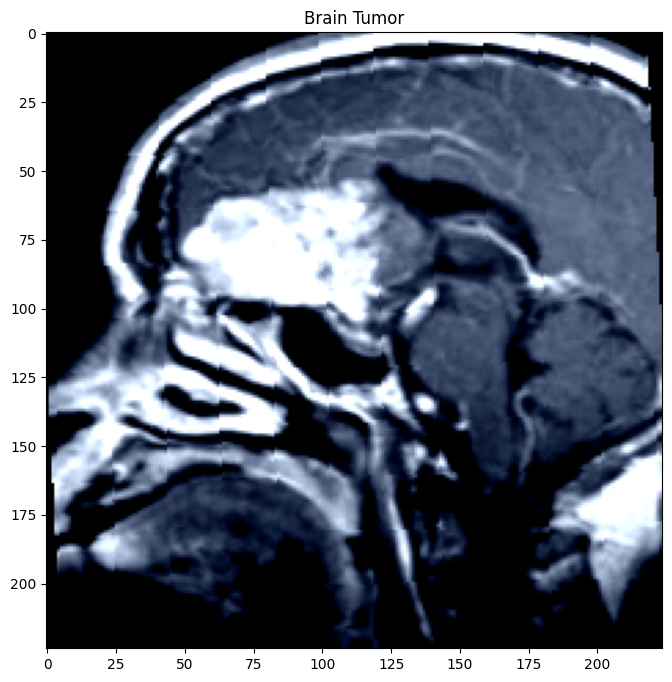

In [7]:

show_image(train_set[0][0], title="Brain Tumor", figsize=(8,8))

#Função para inicializar os pesos do modelo

In [8]:
def weights_init(m):
    name = m.__class__.__name__

    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

Definição da arquitetura do Gerador

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu, tipos):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        """
        ===== CNN Architecture (AlexNet) ======

        * Encoder has the following architecture:
        1) C64, ReLu, Pool
        2) C192, ReLu, Pool
        3) C384, ReLu
        4) C256, ReLu
        5) C256, ReLu, Pool
        6) AdaptativeAvgPool
        7) Flatten
        9) Dropout, Linear , ReLu
        8) Dropout, Linear , ReLu
        10) Dropout, Linear

        """


        self.lay1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.lay2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.lay3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.lay4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.lay5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.lay6 = nn.AdaptiveAvgPool2d((6, 6))

        self.lay7 = nn.Flatten()

        self.lay8 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True)
        )

        self.lay9 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)

        )

        self.lay10 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, tipos)
        )




    def forward(self, x):

        l1 = self.lay1(x)
        l2 = self.lay2(l1)
        l3 = self.lay3(l2)
        l4 = self.lay4(l3)
        l5 = self.lay5(l4)

        l6 = self.lay6(l5)
        l7 = self.lay7(l6)

        l8 = self.lay8(l7)
        l9 = self.lay9(l8)

        out = self.lay10(l9)

        return out

#Inicialização do Gerador

In [10]:
model = Generator(ngpu=1, tipos=4)

if(device == "cuda" and ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

model.apply(weights_init)
model.to(device)

Generator(
  (lay1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lay2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lay3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (lay4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (lay5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lay6): AdaptiveAvgPool2d(output_size=(6, 6))
  (lay7): Flatten(start_dim=1, end_d

#Carregamento da rede salva

In [11]:
model = torch.load("/content/drive/MyDrive/Tumor/tumorNet.pth")

#Inicialização dos otimizadores e treinamento da rede

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = 0.005, momentum = 0.9)

model.to(device)
print()

In [13]:
metrics = {
    'train': {
         'loss': [], 'accuracy': []
    },
    'val': {
         'loss': [], 'accuracy': []
    },
}

#Train model
train_loss=[]
train_accuary=[]
valid_loss=[]
valid_accuary=[]


start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        # forward inputs and get output
        def closure():
          if torch.is_grad_enabled():
              optimizer.zero_grad()
          outputs=model(image)
          _, preds = torch.max(outputs, 1)
          loss=criterion(outputs,label)
          if loss.requires_grad:
              loss.backward()
          return loss
        optimizer.step(closure)
        # only for diagnostics
        outputs=model(image)
        loss=criterion(outputs,label)
        _, preds = torch.max(outputs, 1)
        #running_loss +=loss.data.item()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == label.data).item()
    epoch_loss = running_loss / len(train_set)
    epoch_acc = running_corrects / len(train_set) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == label.data).item()
        epoch_loss = running_loss / len(val_set)
        epoch_acc = running_corrects / len(val_set) * 100.
        # Append result
        valid_loss.append(epoch_loss)
        valid_accuary.append(epoch_acc)
        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))
        torch.save(model, "/content/drive/MyDrive/Tumor/tumorNet.pth")


Epoch 0 running
[Train #1] Loss: 0.0033 Acc: 91.7798% Time: 16.1405s
[Validation #1] Loss: 0.0043 Acc: 91.4530% Time: 105.4726s
Epoch 1 running
[Train #2] Loss: 0.0039 Acc: 88.9921% Time: 116.6798s
[Validation #2] Loss: 0.0054 Acc: 87.7493% Time: 119.1847s
Epoch 2 running
[Train #3] Loss: 0.0032 Acc: 91.4939% Time: 129.9683s
[Validation #3] Loss: 0.0051 Acc: 89.4587% Time: 132.0410s
Epoch 3 running
[Train #4] Loss: 0.0033 Acc: 90.8506% Time: 147.1309s
[Validation #4] Loss: 0.0047 Acc: 90.0285% Time: 149.5260s
Epoch 4 running
[Train #5] Loss: 0.0033 Acc: 90.2073% Time: 161.6809s
[Validation #5] Loss: 0.0061 Acc: 86.3248% Time: 163.5082s
Epoch 5 running
[Train #6] Loss: 0.0030 Acc: 92.0658% Time: 176.4940s
[Validation #6] Loss: 0.0054 Acc: 88.6040% Time: 178.1864s
Epoch 6 running
[Train #7] Loss: 0.0031 Acc: 91.7798% Time: 193.1385s
[Validation #7] Loss: 0.0046 Acc: 90.3134% Time: 194.6857s
Epoch 7 running
[Train #8] Loss: 0.0031 Acc: 91.9943% Time: 208.7821s
[Validation #8] Loss: 0.0046